In [2]:
%reload_ext autoreload
%autoreload 2

import argparse
import os
import glob
import numpy as np
import torch
from networks.mmt import MMT as generator
from torchvision.utils import save_image
from tqdm import tqdm
from configs.config import get_config
from datasets.dataset_brats import BRATS_dataset, RandomGeneratorBRATS
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import Upsample
from skimage.transform import resize

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"


split = 'test'
batch_size = 1
data_dir = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/brats2021_slices_crop192x160'
ckpt_path_zerogad = '/mnt/datasets/jiang/projects/SubtleGAN/model_fluidstack/MMT/MMTUNetHybrid_GAN_ls_zerogad_s_c_MMT_epo50_bs32_lrg0.0005_192_opt-adamw/epoch_31.pth'
ckpt_path_random = '/mnt/datasets/jiang/projects/SubtleGAN/model_fluidstack/MMT/MMTUNetHybrid_GAN_ls_random_s_c_MMT_epo75_bs32_lrg0.0005_192_opt-adamw/epoch_74.pth'
ckpt_path_single = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/MMTUNetHybrid/model/fluidstack_models/finetuned_models/MMT_single_epo100_bs32_lrg0.0005_5.0_20.0_0.0_0.1/best_mae.pth'

ckpt_no_cross_attn = '/home/srivathsa/projects/SubtleGad/train/prototypes/mmt/MMTUNetHybrid/model/MMT_single_no_cross_atn_epo100_bs24_lrg0.0005_5.0_20.0_0.0_0.1_vgg0/best_mae.pth'
ckpt_ixi = '/home/srivathsa/projects/SubtleGad/train/prototypes/mmt/MMTUNetHybrid/model/IXI_single_no_cross_atn_epo100_bs16_lrg0.0005_5.0_20.0_0.0_0.1_vgg0/best_mae.pth'
ckpt_path = ckpt_path_single

db = BRATS_dataset(base_dir=data_dir, split=split,
                               transform=transforms.Compose(
                                   [RandomGeneratorBRATS(flip=False, scale=None)]))
dataloader = DataLoader(db, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
G = generator(img_size=[160, 192],
                                patch_size=4,
                                in_chans=1,
                                out_chans = 1,
                                embed_dim=96,
                                depths=[2,2,2,2],
                                num_heads=[3,6,12,24],
                                window_size=[5, 6],
                                mlp_ratio=4.0,
                                qkv_bias=True,
                                qk_scale=None,
                                drop_rate=0,
                                drop_path_rate=0,
                                ape=False,
                                patch_norm=True,
                                use_checkpoint=False, cross_contrast_attn=True).cuda()
state_dict = torch.load(ckpt_path, map_location='cpu')
G.load_state_dict(state_dict['G'])
G.eval()


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0
CROSS CONTRAST ATTN= True
---final upsample expand_first---


MMT(
  (heads): ModuleList(
    (0): Head(
      (model): Sequential(
        (0): Conv2d(1, 6, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ResBlock(
          (body): Sequential(
            (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): ReLU(inplace=True)
            (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
        (2): ResBlock(
          (body): Sequential(
            (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): ReLU(inplace=True)
            (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
      )
    )
    (1): Head(
      (model): Sequential(
        (0): Conv2d(1, 6, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ResBlock(
          (body): Sequential(
            (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): ReLU(inplace=True)
    

In [3]:
def slice_loader(fn):
    data = np.load(fn)
    n_channel = data.shape[0]
    image = torch.from_numpy(data.astype(np.float32)).unsqueeze(0)
    output = [image[:, i, :, :].unsqueeze(0).detach() for i in range(n_channel)]
    return output

In [4]:
def split_data(data, inputs, targets):
    contrast_input = inputs
    contrast_output = targets
    img_inputs = [data[i].detach().cuda() for i in contrast_input]
    img_targets = [data[i].detach().cuda() for i in contrast_output]
    return img_inputs, img_targets, contrast_input, contrast_output

In [5]:
from torch.nn.functional import interpolate
import torch
from torch.nn.functional import softmax

def sum_attn(attn_maps, head_normalization=True, return_indiv=False):
    indiv_attns = []
    n_heads = [24, 24, 12, 12, 6, 6, 3, 3]
    attn = torch.zeros_like(attn_maps[-1][:, :, :, :, 0])
    for n_head, attn_map in zip(n_heads, attn_maps):
        attn_map = attn_map[:, :, :, :, 0]
        scale_factor = 48//attn_map.shape[-1]
        attn_map = interpolate(attn_map, size=(40, 48))/scale_factor**2
        if head_normalization:
            attn_map = attn_map/n_head
        
        indiv_attns.append(attn_map)
        
        attn += attn_map
    
    if return_indiv:
        return attn, indiv_attns
    return attn

In [7]:
data = slice_loader('/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/brats2021_slices_crop192x160/test/BraTS2021_01409/077.npy')
data = [d.detach().cuda() for d in data]
img_inputs, img_targets, contrast_input, contrast_output = split_data(data, [0,2,3], [1])

In [8]:
outputs, _, attn = G(
    img_inputs, contrast_input, contrast_output, return_attention=True
)

(-0.5, 159.5, 191.5, -0.5)

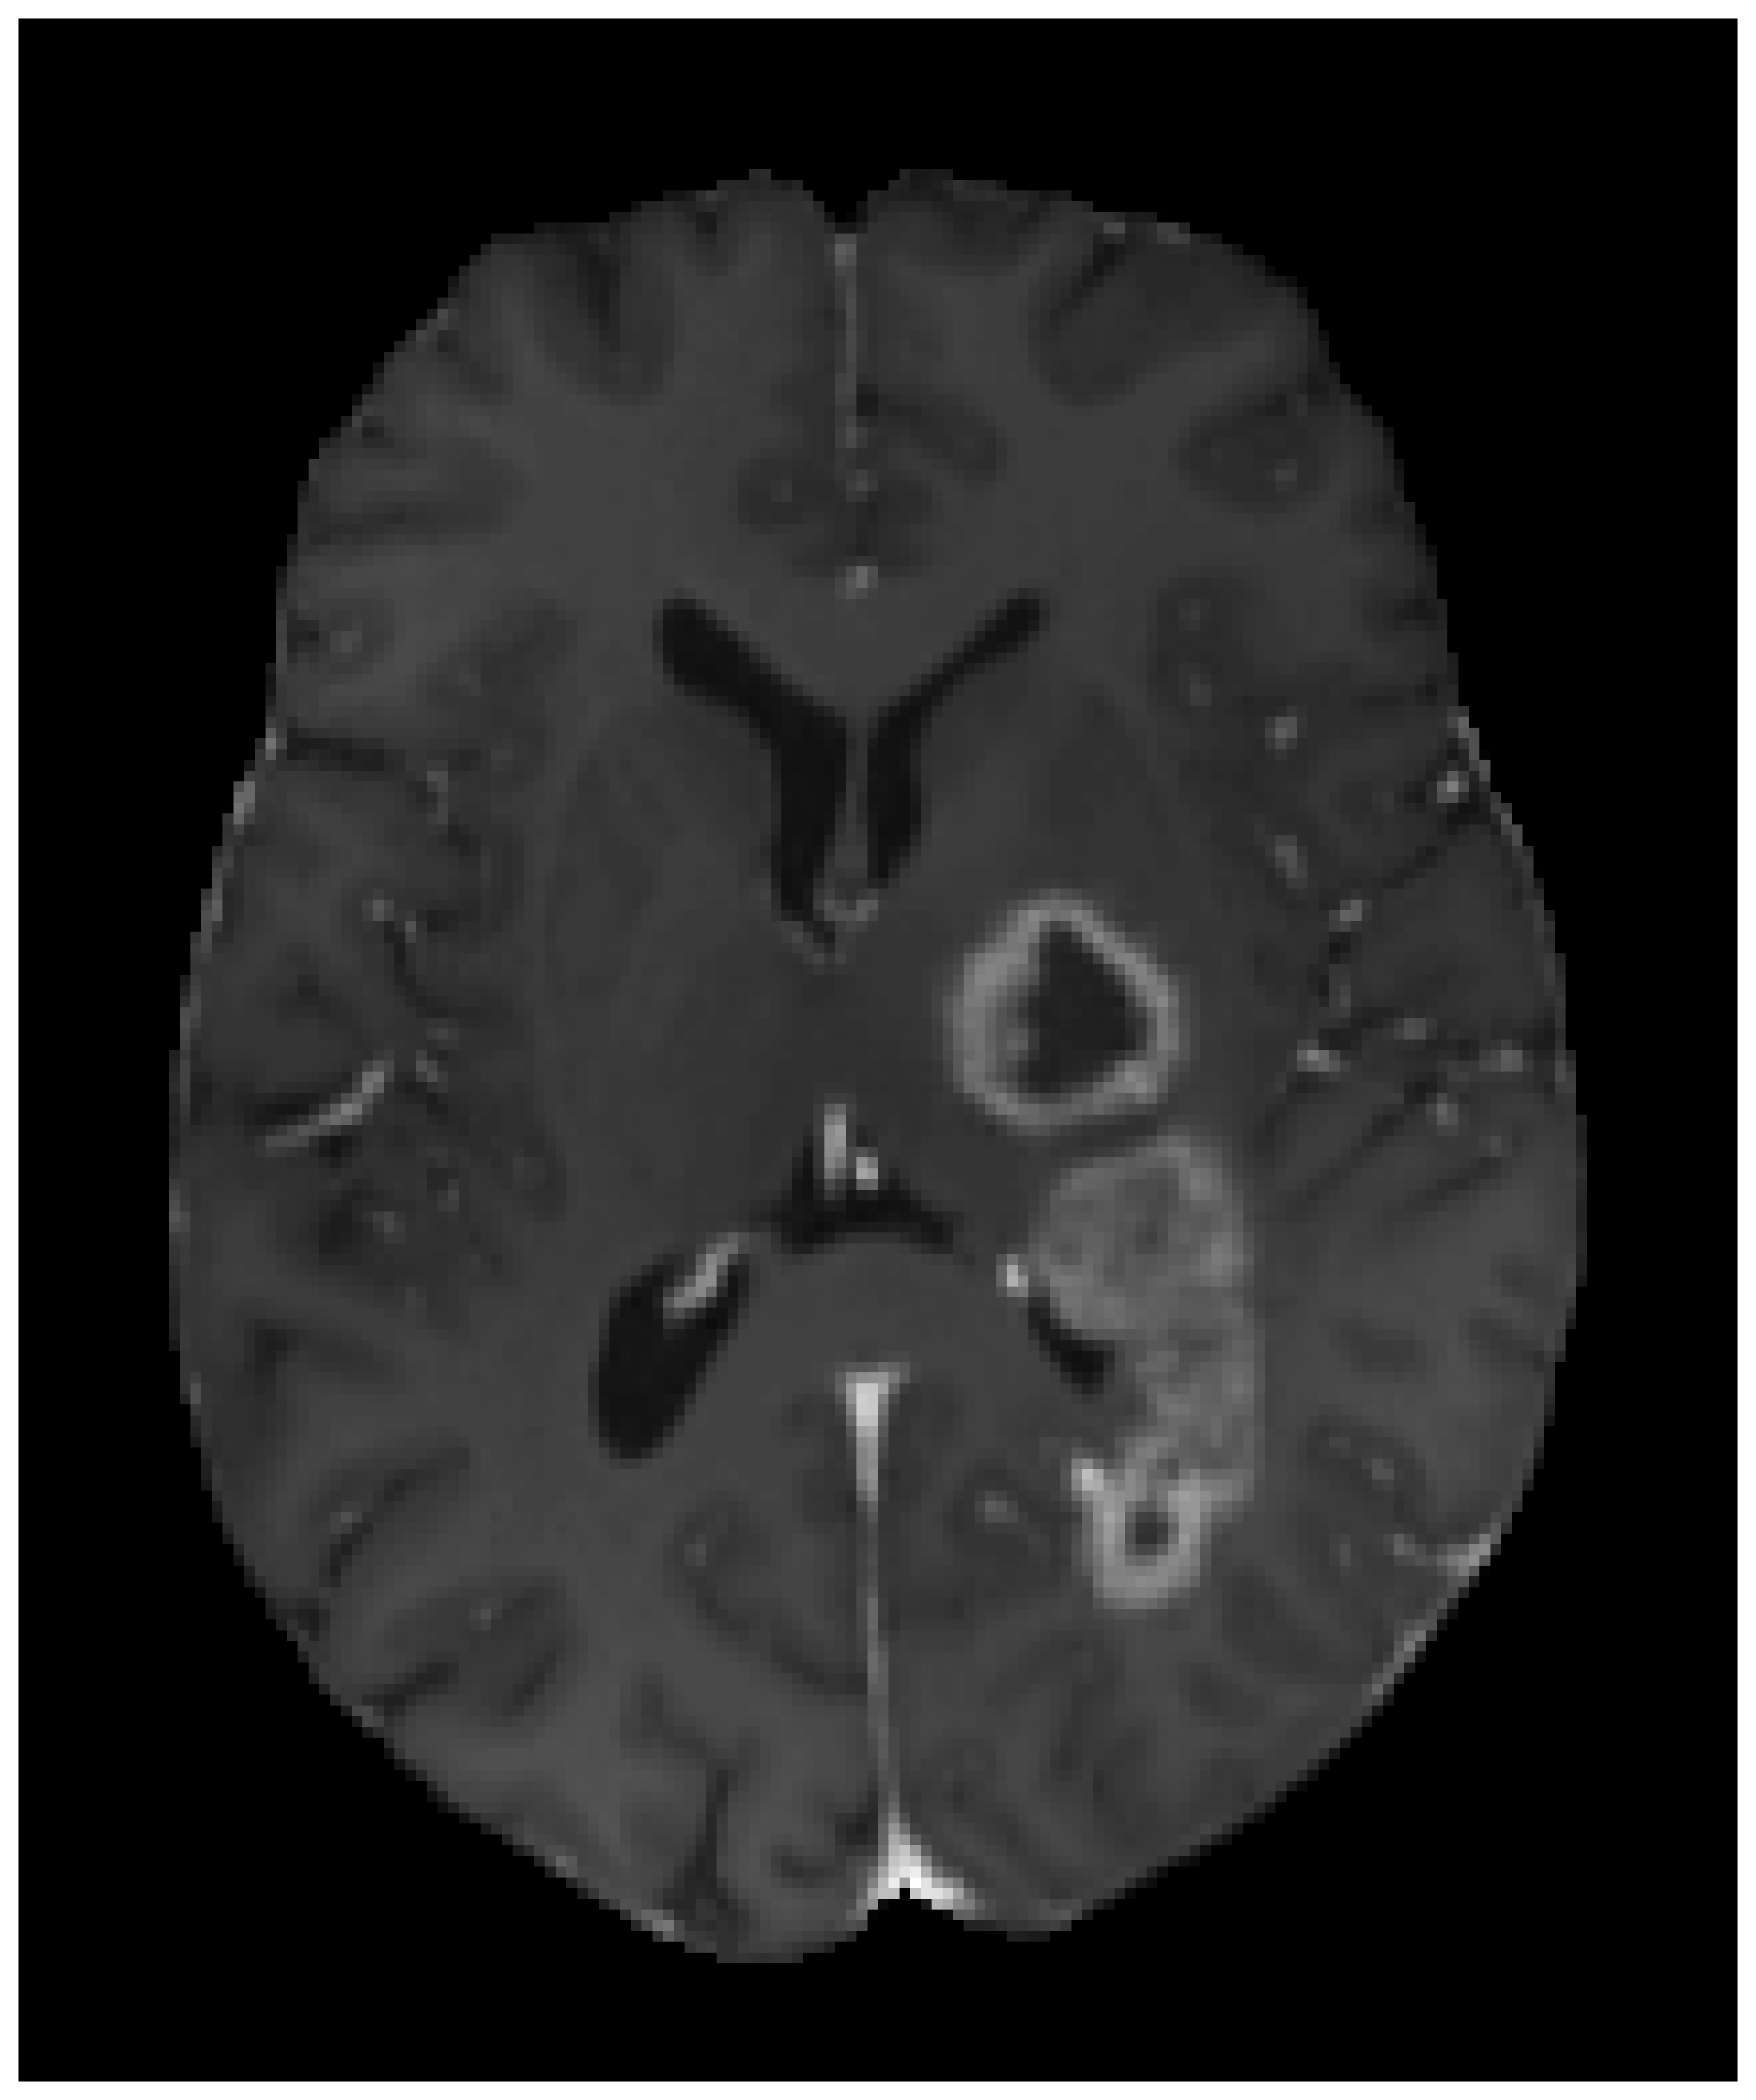

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 15)
plt.rcParams['figure.dpi'] = 300

syn = outputs[0].detach().cpu().numpy().squeeze()

plt.imshow(np.rot90(syn, k=3), cmap='gray')
plt.axis('off')

In [14]:
att_sum = sum_attn(attn, True)
#att_sum = softmax(att_sum, dim = 1)
from torch.nn.functional import normalize
att_sum = normalize(att_sum, p=1, dim=1)
att_sum = torch.rot90(att_sum, 3, [2, 3])

In [15]:
ip_imgs = []
for idx in range(4):
    img = data[idx].detach().cpu().numpy().squeeze()
    img = np.rot90(img, k=3)
    img = img/img.mean()
    ip_imgs.append(img)

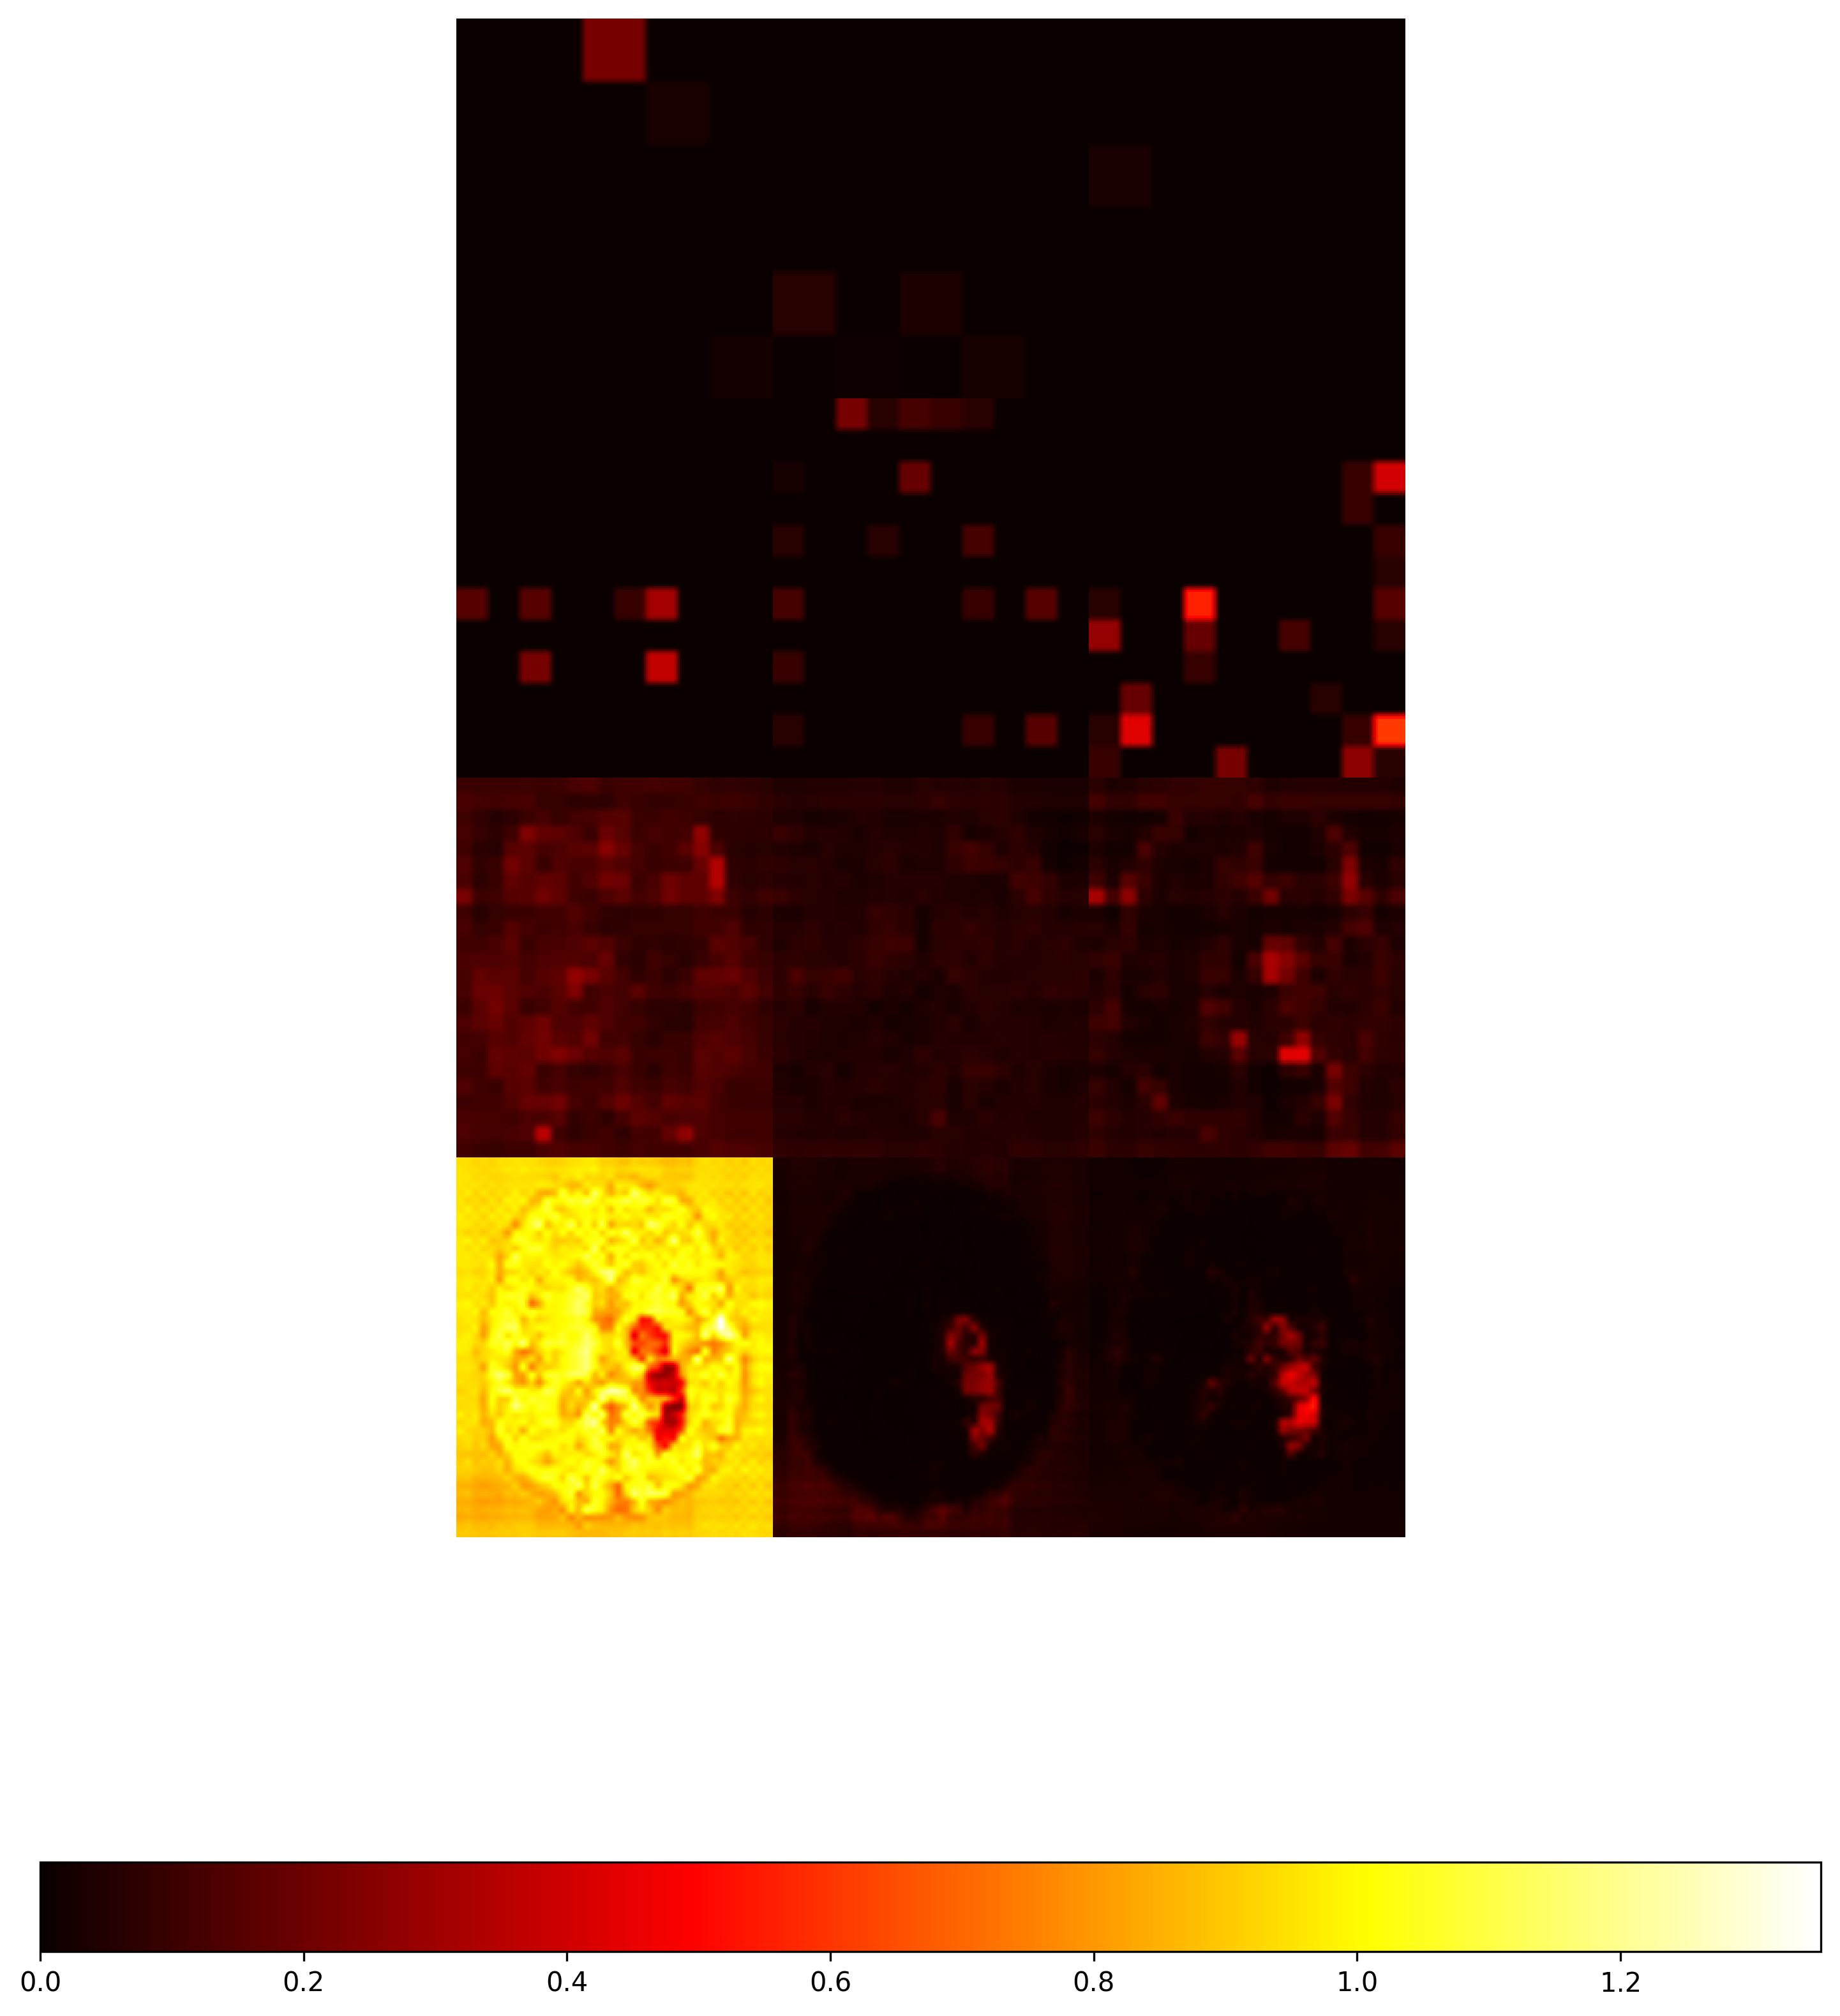

In [30]:
att_sum, att_indiv = sum_attn(attn, True, True)

att_proc = []
for idx, att_ind in enumerate(att_indiv):
    if idx % 2 == 0: continue
    indiv_map = att_ind.detach().cpu().numpy().squeeze()
    indiv_map = np.rot90(indiv_map, 3, [1, 2])
    indiv_map = resize(indiv_map, output_shape=(3, 192, 160))
    att_proc.append(indiv_map)

indiv_map = np.array(att_proc)

disp_img = []
for idx in [0, 2, 3]:
    row = np.vstack([ip_imgs[idx]]*4)
    disp_img.append(row)
disp_img = np.hstack(disp_img)

disp_hmap = []
for idx in range(3):
    row = np.vstack([*indiv_map[:, idx]])
    disp_hmap.append(row)
disp_hmap = np.hstack(disp_hmap)

# plt.imshow(disp_img, cmap='gray', alpha=1)
plt.imshow(disp_hmap, cmap='hot', alpha=1)
plt.axis('off')
plt.colorbar(orientation='horizontal')

In [ ]:
att_sum = att_sum.detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(att_sum[0, 0, :, :])
plt.colorbar()
plt.axis('off')
#plt.clim(0, 1)
plt.savefig("Fig/attn_t1.png")

In [ ]:
plt.imshow(att_sum[0, 1, :, :])
plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_t2.png")

In [ ]:
plt.imshow(att_sum[0, 2, :, :])
plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_flair.png")

In [ ]:
print(len(attn))

In [ ]:
att_last = torch.rot90(attn[-1], 3, [2, 3])
#att_last = softmax(att_last[:, :, :, :, 0], dim=1)
#from torch.nn.functional import normalize
#att_last = normalize(att_last, p=1, dim=1)
#att_last = att_last/torch.sum(att_last)
att_last = att_last.detach().cpu().numpy()

In [ ]:
plt.imshow(att_last[0, 0, :, :], cmap='hot')
plt.clim(0,4.3)
#plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_t1_last.png")

In [ ]:
plt.imshow(att_last[0, 1, :, :], cmap='hot')
#plt.clim(0,1)
plt.clim(0,4.3)
#plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_t2_last.png")

In [ ]:
plt.imshow(att_last[0, 2, :, :], cmap='hot')
#plt.clim(0,1)
plt.clim(0,4.3)
# plt.colorbar(orientation='horizontal')
plt.axis('off')
plt.savefig("Fig/attn_flair_last.png")

In [ ]:
plt.imshow(np.concatenate((att_last[0, 2, :, :],att_last[0, 2, :, :],att_last[0, 2, :, :],att_last[0, 2, :, :],att_last[0, 2, :, :]),axis=1), cmap='hot')
#plt.clim(0,1)
plt.clim(0,4.3)
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.colorbar(orientation='horizontal', aspect=40)
plt.axis('off')
plt.savefig("Fig/legend.png")

In [ ]:
att_last.shape

In [ ]:
5760/64

In [ ]:
len(attn)

In [ ]:
attn[-1].shape

In [ ]:
att_last.max()